<a href="https://colab.research.google.com/github/JCaballerot/Consultoria_ASEI/blob/main/Consultoria_ASEI/EXPLORATORIO/utilities/modeling/modelDevelopment_zona2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias



Cargamos las librerías que utilizaremos en el proyecto

In [ ]:
import pandas as pd

import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from sklearn.metrics import *

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",  color='red')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)

# Data

Importamos la información desde un archivo csv cargado en el file temporal y nos quedamos con los datos de la zona 2

In [ ]:
pddf = pd.read_csv('datos_miraflores.csv', index_col=['codmes'], parse_dates=['codmes']).fillna(0)
pddf = pddf[['Oferta_zona_2', 'Venta_zona_2']]


In [ ]:

macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])
variables_macro = macro.columns.tolist()

macro[variables_macro] = macro[variables_macro].shift(3)



In [ ]:
pddf2 = pd.merge(pddf, macro, on = 'codmes', how='left').copy()
variables = variables_macro + ['Oferta_zona_2']


In [ ]:
pddfRes = pddf2.copy()

pddfRes[[x + '_avg3' for x in variables]] = pddfRes[variables].rolling(3, min_periods = 3).mean()
pddfRes[[x + '_avg6' for x in variables]] = pddfRes[variables].rolling(6, min_periods = 6).mean()

pddfRes = pddfRes.iloc[8:]

In [ ]:
for x in variables:
  pddfRes[x + '_rat3to6'] = pddfRes[x + '_avg3']/pddfRes[x + '_avg6']
  

# Forecasting

Muestreamos la data en train y test bajo metodología OOT

In [ ]:
pddfTS = pddf[['Venta_zona_2']].copy()

X_train = pddfTS[:-4]
X_test  = pddfTS[-4:]


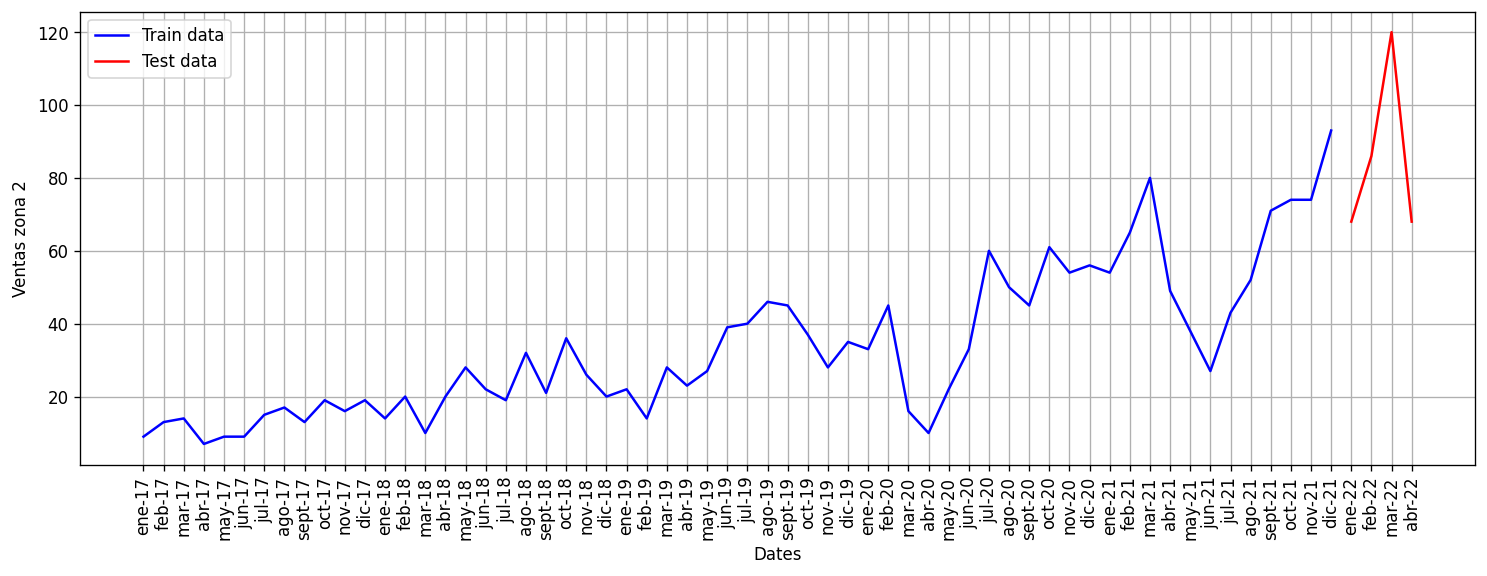

In [ ]:
#split data into train and training set
plt.figure(figsize=(15,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Ventas zona 2')
plt.plot(X_train, 'blue', label='Train data')
plt.plot(X_test, 'red', label='Test data')
plt.xticks(rotation=90)
plt.legend()

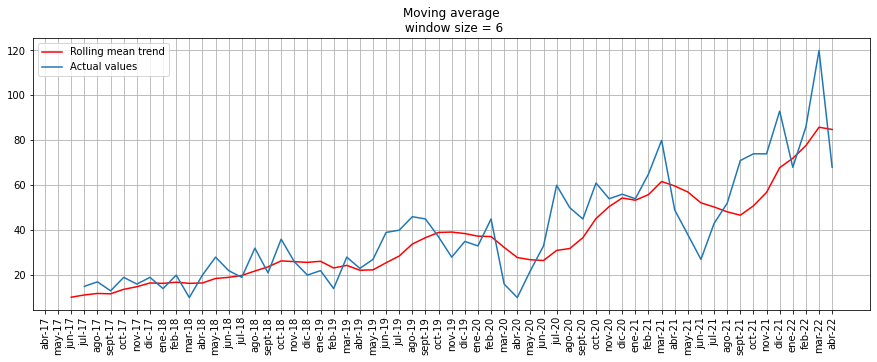

In [ ]:
plotMovingAverage(pddfTS['Venta_zona_2'], 6)

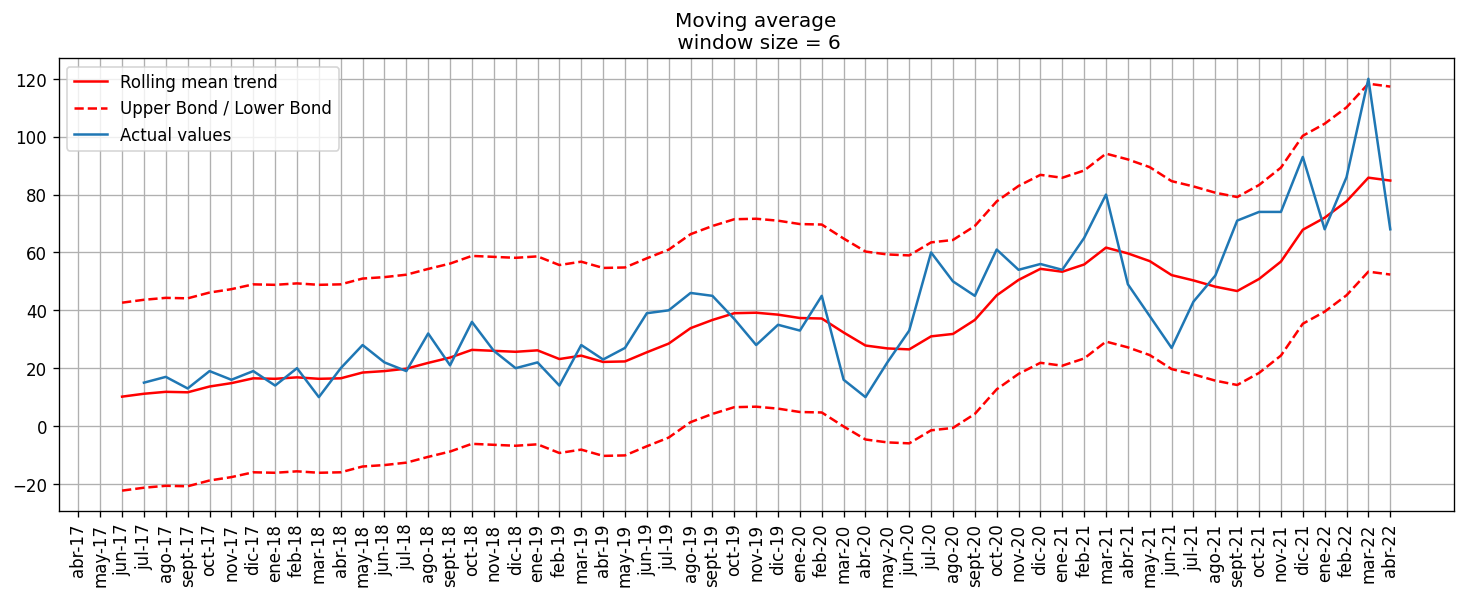

In [ ]:
plotMovingAverage(pddfTS['Venta_zona_2'], 6, plot_intervals=True, scale=1.96, plot_anomalies=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(X_train.Venta_zona_2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.231261
p-value: 0.660005


Dado que el valor p es mayor que el nivel de significancia (0,05), diferenciemos las series y veamos cómo se ve el gráfico de autocorrelación.

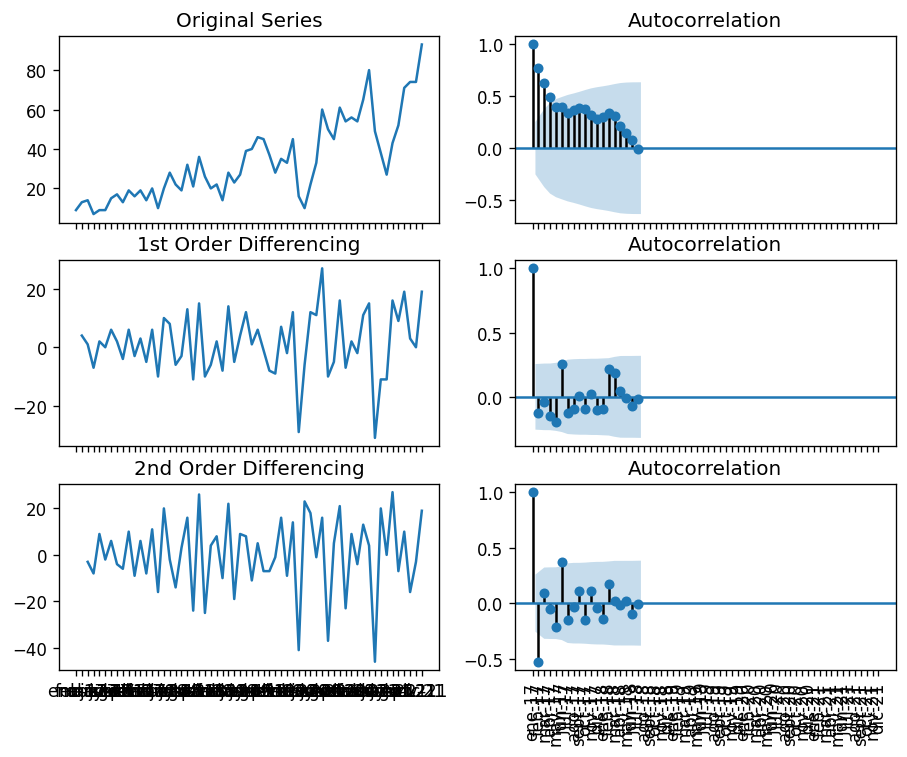

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train.Venta_zona_2); axes[0, 0].set_title('Original Series')
plot_acf(X_train.Venta_zona_2, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train.Venta_zona_2.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train.Venta_zona_2.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train.Venta_zona_2.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train.Venta_zona_2.diff().diff().dropna(), ax=axes[2, 1])

plt.xticks(rotation=90)
plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con dos órdenes de diferenciación.

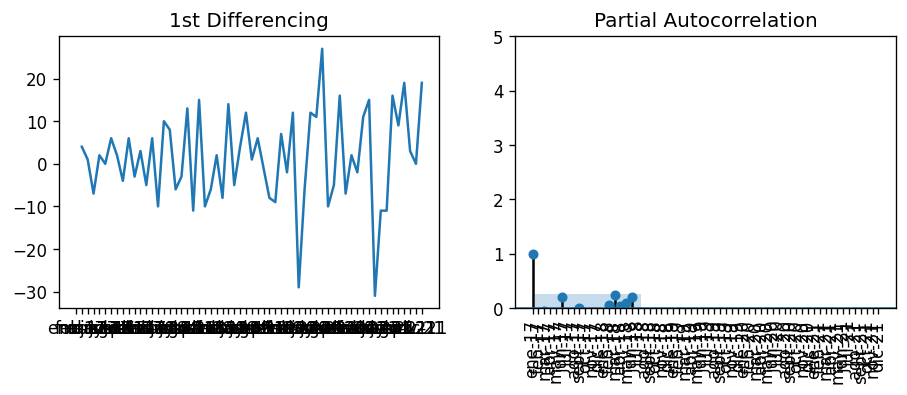

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train.Venta_zona_2.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(X_train.Venta_zona_2.diff().dropna(), ax=axes[1])

plt.xticks(rotation=90)
plt.show()

Podemos ver que el retraso 1 de PACF es bastante significativo ya que está muy por encima de la línea de significancia. Entonces, fijaremos el valor de p como 1.

### MA (q) 

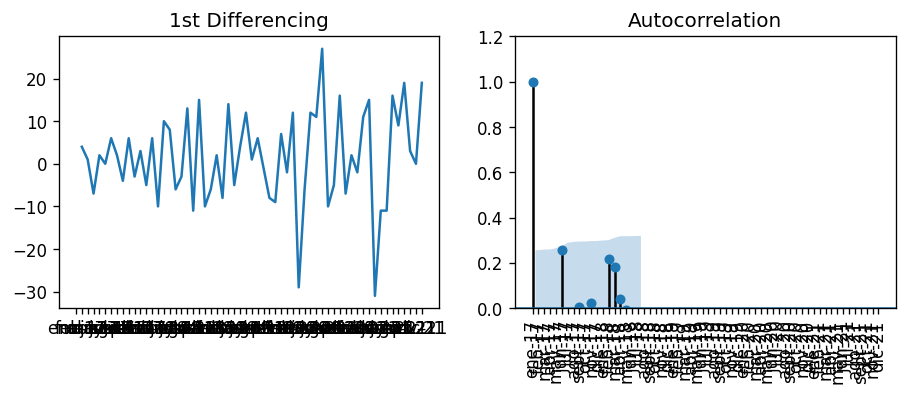

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train.Venta_zona_2.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(X_train.Venta_zona_2.diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()


Podemos ver que un 1 retraso están muy por encima de la línea de significación. Entonces, fijaremos q como 1. Si hay alguna duda, iremos con el modelo más simple que explica suficientemente la Y

### Arima

Ahora, hemos determinado los valores de p, d y q. Disponemos de todo lo necesario para adaptarse al modelo ARIMA. Usaremos la implementación ARIMA() en el paquete statsmodels.
(p,d,q)

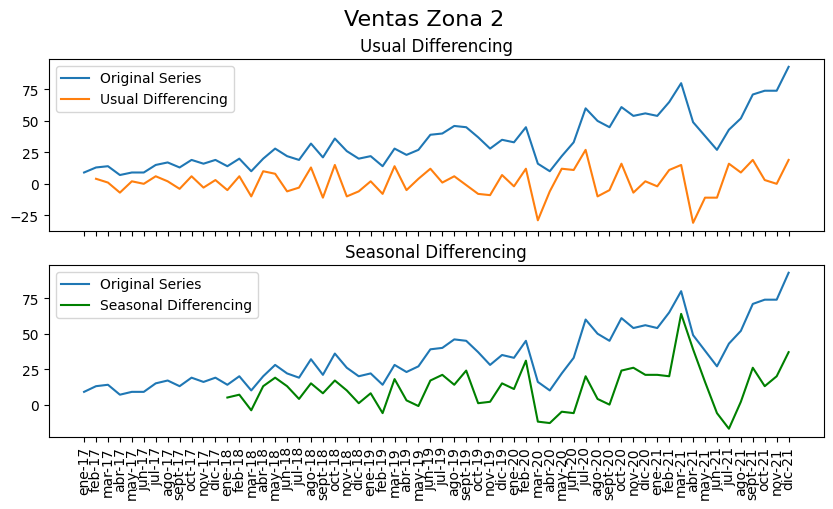

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X_train.Venta_zona_2, label='Original Series')
axes[0].plot(X_train.Venta_zona_2.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(X_train.Venta_zona_2, label='Original Series')
axes[1].plot(X_train.Venta_zona_2.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas Zona 2', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(X_train.Venta_zona_2, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.Venta_zona_2   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -219.383
Method:                       css-mle   S.D. of innovations              9.739
Date:                Tue, 14 Jun 2022   AIC                            446.765
Time:                        16:45:35   BIC                            455.076
Sample:                             1   HQIC                           450.009
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0277      0.172      5.961      0.000       0.690       1.366
ar.L1.D.Venta_zona_2     0.6036      0.119      5.075      0.000       0.370       0.837
ma.L1.D.Vent

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X_train.Venta_zona_2, order=(1,1,1), seasonal_order = (1,1,1,12))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                       Venta_zona_2   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -184.519
Date:                            Tue, 14 Jun 2022   AIC                            379.039
Time:                                    05:47:32   BIC                            388.290
Sample:                                         0   HQIC                           382.520
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6386      0.260      2.460      0.014       0.130       1.147
ma.L1         -0.9557      0.230   

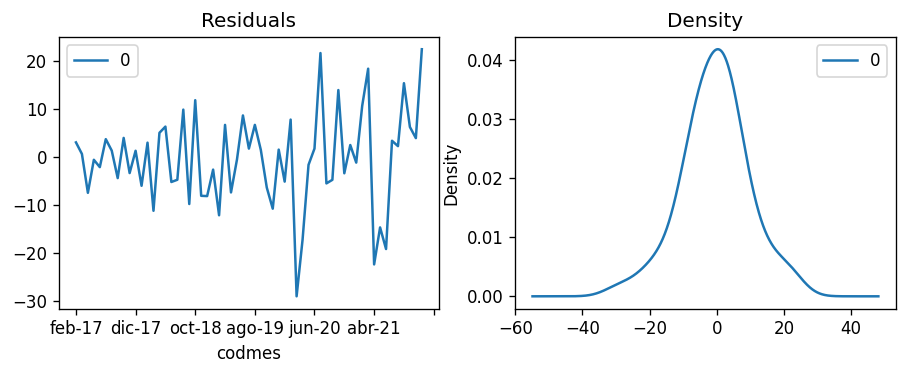

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen correctos con una media cercana a cero y una varianza uniforme. Grafiquemos los valores reales contra los valores ajustados usando plot_predict().

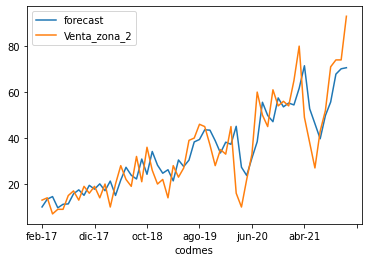

<Figure size 1080x576 with 0 Axes>

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

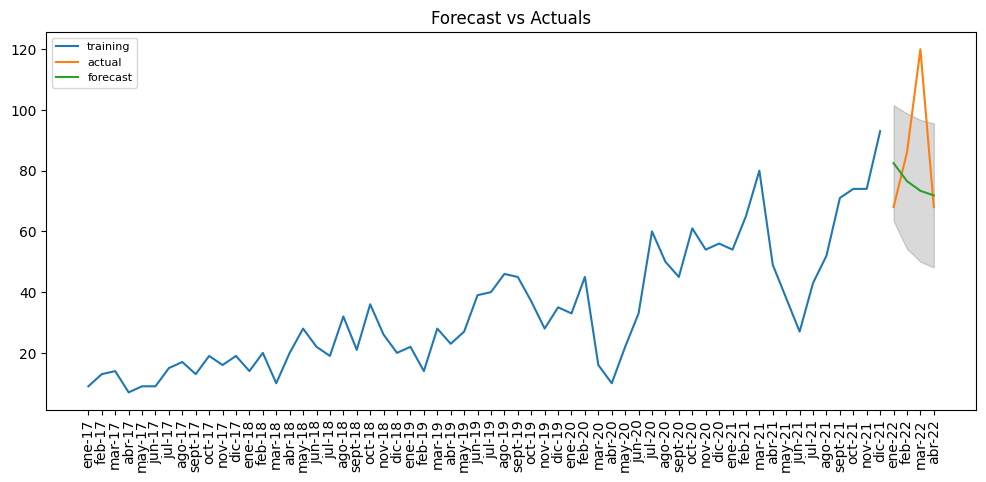

In [ ]:

# Forecast
fc, se, conf = model_fit.forecast(4, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf[:, 0], index=X_test.index)
upper_series = pd.Series(conf[:, 1], index=X_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train, label='training')
plt.plot(X_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=90)
plt.show()

In [ ]:
fc, se, conf  = model_fit.forecast(10, alpha=0.05)
fc

array([82.48422348, 76.54451208, 73.36681646, 71.85621493, 71.35183599,
       71.45479166, 71.9243216 , 72.615108  , 73.43944009, 74.34437752])

In [ ]:
model_res = model_fit.predict(start = 'feb-17' , end = 'dic-21', dynamic=False, typ = 'levels')

In [ ]:
pddfTS_res = pddfTS.copy()
pddfTS_res['venta_predicted'] = model_res

In [ ]:
fc, se, conf  = model_fit.forecast(4, alpha=0.05)

In [ ]:
pddfTS_res.iloc[-4:]['venta_predicted'] = fc

In [ ]:
pddfTS_res

,Venta_zona_2,venta_predicted
codmes,,
ene-17,9,NaN
feb-17,13,10.027665
mar-17,14,13.438516
abr-17,7,14.542365
may-17,9,9.654124
...,...,...
dic-21,93,70.607072
ene-22,68,82.484223
feb-22,86,76.544512


# Regresión

In [ ]:
pddfReg = pddfRes.copy()
pddfReg['venta_predicted'] = pddfTS_res[['venta_predicted']].iloc[8:].venta_predicted

In [ ]:
target = 'Venta_zona_2'

total_features = variables +\
                 [x + '_avg3' for x in variables] +\
                 [x + '_avg6' for x in variables] +\
                 [x + '_rat3to6' for x in variables] + ['venta_predicted']

In [ ]:
X_train_reg = pddfReg[:-4]
X_test_reg  = pddfReg[-4:]

In [ ]:
correlations = pd.DataFrame()
data = X_train_reg.copy()

for col in total_features:
  data_temp = data[[target, col]]
  correlation = data_temp[col].corr(data_temp[target])
  temp = pd.DataFrame({'target': [target],'variable': [col], 'correlacion' : [correlation]})
  correlations = correlations.append(temp)

correlations['correlacion_abs'] = correlations.correlacion.apply(lambda x: abs(x))
correlations.sort_values(by = 'correlacion_abs', ascending = False, inplace = True)


In [ ]:
correlations.head(50)

,target,variable,correlacion,correlacion_abs
0,Venta_zona_2,venta_predicted,0.849793,0.849793
0,Venta_zona_2,ind_prec_12_distr,0.825511,0.825511
0,Venta_zona_2,ind_prec_alt,0.824984,0.824984
0,Venta_zona_2,ind_prec_12_distr_avg3,0.820910,0.820910
0,Venta_zona_2,ind_prec_alt_avg3,0.819387,0.819387
0,Venta_zona_2,ind_prec_med,0.809715,0.809715
0,Venta_zona_2,tip_camb_banc_venta_avg3,0.809472,0.809472
0,Venta_zona_2,ind_prec_cons_lima_met_alim_ener_avg6,0.807394,0.807394
0,Venta_zona_2,ind_prec_cons_lima_met_alim_ener,0.806367,0.806367
0,Venta_zona_2,ind_prec_med_avg3,0.805754,0.805754


Text(0, 0.5, 'Venta_zona_2')

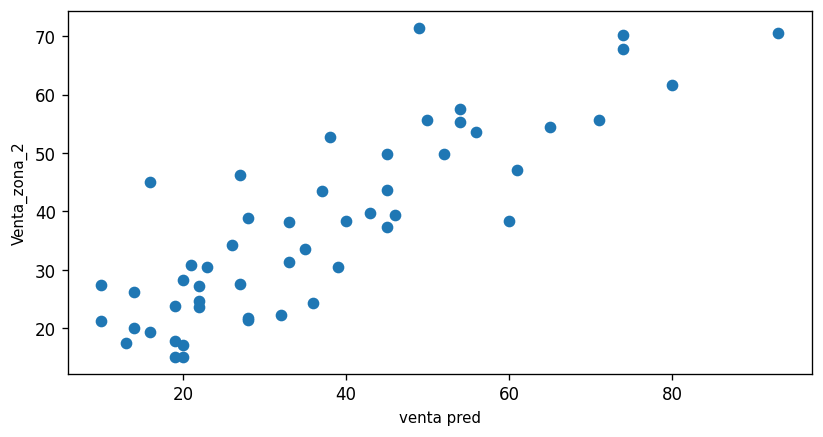

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.venta_predicted)
plt.xlabel("venta pred", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Tipo de cambio

Text(0, 0.5, 'Venta_zona_2')

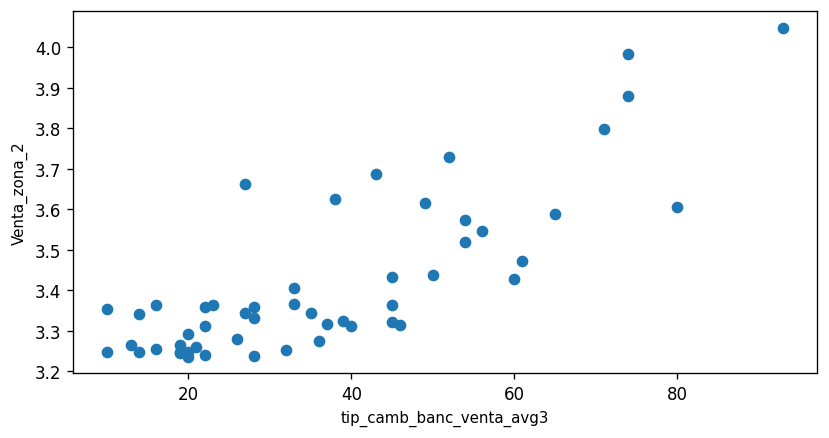

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.tip_camb_banc_venta_avg3)
plt.xlabel("tip_camb_banc_venta_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Indice de precios de inmuebles 12 distritos de lima

Text(0, 0.5, 'Venta_zona_2')

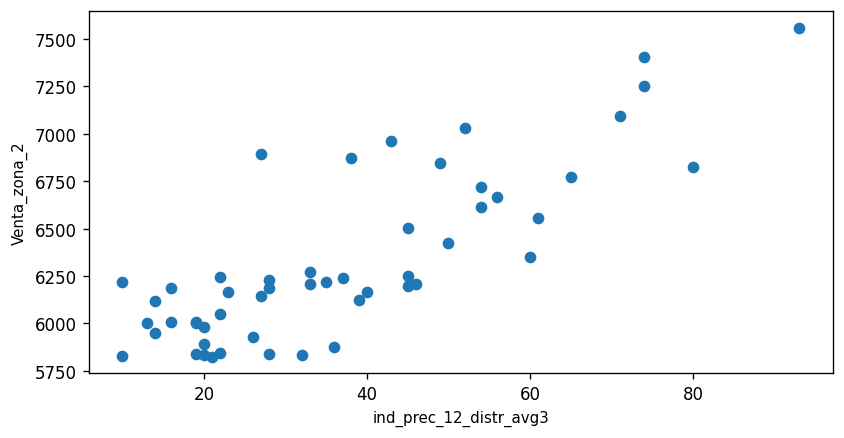

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.ind_prec_12_distr_avg3)
plt.xlabel("ind_prec_12_distr_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Indice de precios al consumidor

Text(0, 0.5, 'Venta_zona_2')

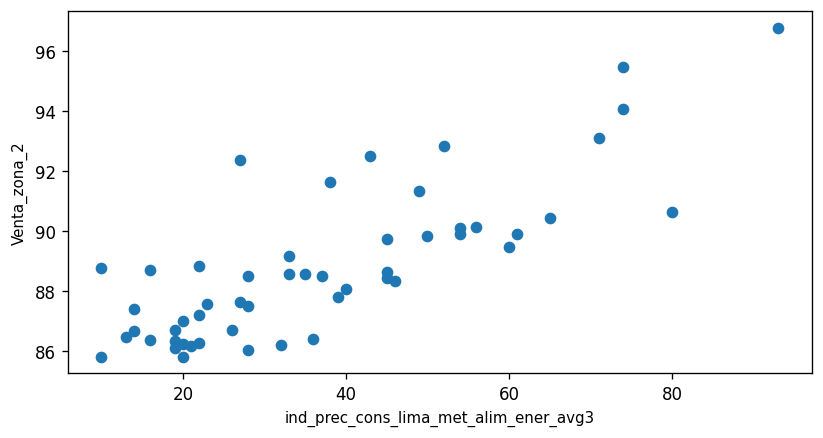

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.ind_prec_cons_lima_met_alim_ener_avg3)
plt.xlabel("ind_prec_cons_lima_met_alim_ener_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Precio de inmuebles distritos altos

Text(0, 0.5, 'Venta_zona_2')

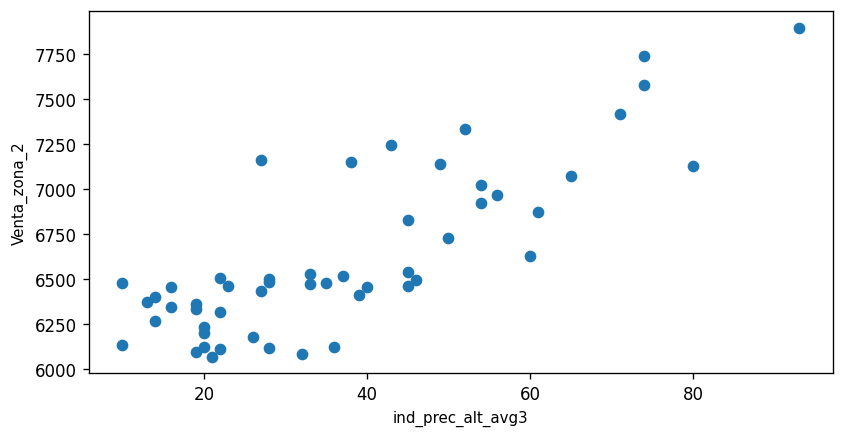

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.ind_prec_alt_avg3)
plt.xlabel("ind_prec_alt_avg3", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Tasa de interes

Text(0, 0.5, 'Venta_zona_2')

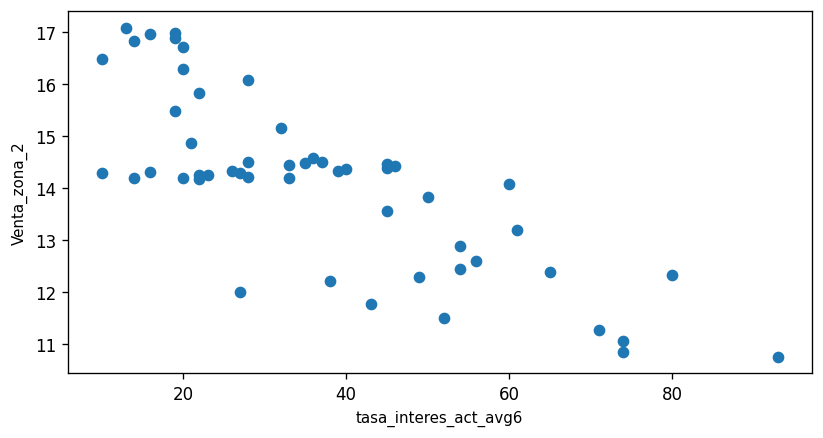

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.tasa_interes_act_avg6)
plt.xlabel("tasa_interes_act_avg6", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

### Oferta en Zona 2

Text(0, 0.5, 'Venta_zona_2')

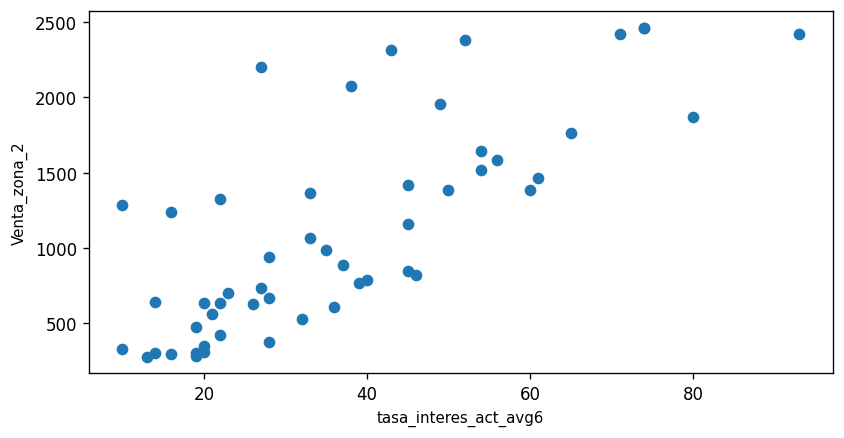

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, X_train_reg.Oferta_zona_2_avg6)
plt.xlabel("tasa_interes_act_avg6", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

Text(0, 0.5, 'Venta_zona_2')

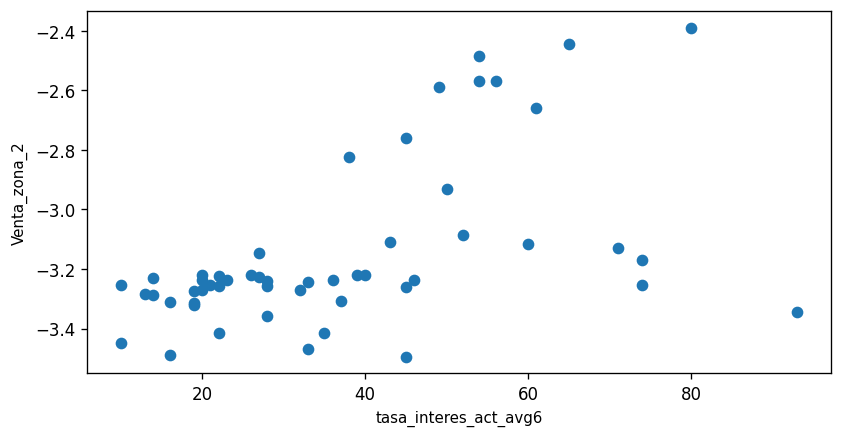

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

plt.scatter(X_train_reg.Venta_zona_2, log(X_train_reg.exp_PBI_avg3))
plt.xlabel("tasa_interes_act_avg6", fontsize=9)
plt.ylabel("Venta_zona_2", rotation=90, fontsize=9)

In [ ]:

X_train_reg_f = X_train_reg[['Venta_zona_2','Oferta_zona_2_avg6', 'exp_PBI_avg3', 'ind_tipo_camb_var_mes_avg3',
             'tasa_interes_act_avg6', 
             'ind_prec_alt_avg3', 
             'ind_prec_cons_lima_met_alim_ener_avg3',
             'ind_prec_12_distr_avg3',
             'tip_camb_banc_venta_avg3',
             'venta_predicted']]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reg_f)

X = scaler.transform(X_train_reg_f)
#X_train_reg_f[[x + '_z' for x in X_train_reg_f.columns]] = 
#pd.DataFrame(X, columns = X_train_reg_f.columns).reset_index(drop=True)

In [ ]:
df = pd.DataFrame(X, columns = [x + '_z' for x in X_train_reg_f.columns]).reset_index(drop=True)

In [ ]:
#df['Venta_zona_2'] = X_train_reg_f['Venta_zona_2'].reset_index(drop=True)

In [ ]:
df.corr()

,Venta_zona_2_z,Oferta_zona_2_avg6_z,exp_PBI_avg3_z,ind_tipo_camb_var_mes_avg3_z,tasa_interes_act_avg6_z,ind_prec_alt_avg3_z,ind_prec_cons_lima_met_alim_ener_avg3_z,ind_prec_12_distr_avg3_z,tip_camb_banc_venta_avg3_z,venta_predicted_z
Venta_zona_2_z,1.000000,0.772941,0.530883,0.555182,-0.788937,0.819387,0.804613,0.820910,0.809472,0.849793
Oferta_zona_2_avg6_z,0.772941,1.000000,0.424528,0.648857,-0.941454,0.943252,0.962890,0.957684,0.939956,0.867231
exp_PBI_avg3_z,0.530883,0.424528,1.000000,0.176187,-0.454485,0.437874,0.317584,0.434444,0.360360,0.570074
ind_tipo_camb_var_mes_avg3_z,0.555182,0.648857,0.176187,1.000000,-0.626384,0.659572,0.660421,0.662240,0.711781,0.515478
tasa_interes_act_avg6_z,-0.788937,-0.941454,-0.454485,-0.626384,1.000000,-0.887591,-0.910871,-0.909017,-0.903792,-0.874433
ind_prec_alt_avg3_z,0.819387,0.943252,0.437874,0.659572,-0.887591,1.000000,0.977846,0.998249,0.979386,0.868822
ind_prec_cons_lima_met_alim_ener_avg3_z,0.804613,0.962890,0.317584,0.660421,-0.910871,0.977846,1.000000,0.984814,0.977936,0.868565
ind_prec_12_distr_avg3_z,0.820910,0.957684,0.434444,0.662240,-0.909017,0.998249,0.984814,1.000000,0.982671,0.878329
tip_camb_banc_venta_avg3_z,0.809472,0.939956,0.360360,0.711781,-0.903792,0.979386,0.977936,0.982671,1.000000,0.846014
venta_predicted_z,0.849793,0.867231,0.570074,0.515478,-0.874433,0.868822,0.868565,0.878329,0.846014,1.000000


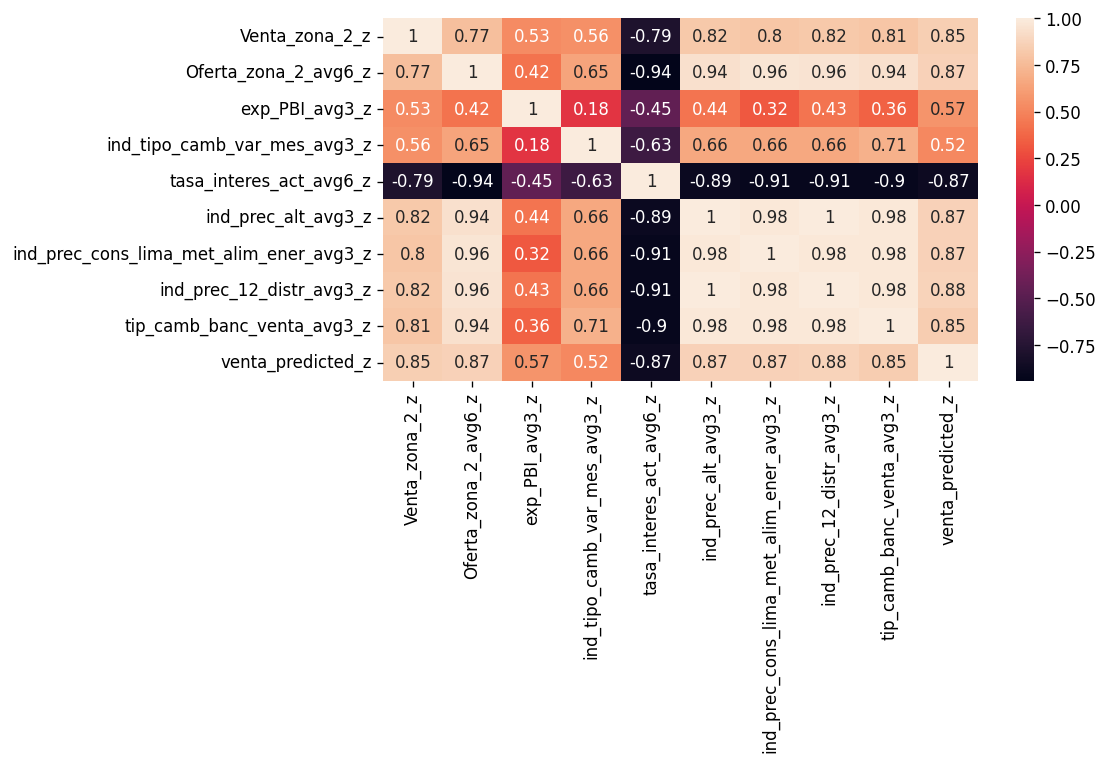

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
df['intercept'] = 1

In [ ]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(df.Venta_zona_2_z, df.drop(columns=['Venta_zona_2_z', 
                                                                     'Oferta_zona_2_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     21.24
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           1.21e-11
Time:                        07:35:02   Log-Likelihood:                -38.856
No. Observations:                  52   AIC:                             91.71
Df Residuals:                      45   BIC:                             105.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
mod = sm.OLS(df.Venta_zona_2_z, df.drop(columns=['Venta_zona_2_z', 'ind_tipo_camb_var_mes_avg3_z',
                                                                     'Oferta_zona_2_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     25.95
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           2.38e-12
Time:                        07:35:16   Log-Likelihood:                -38.937
No. Observations:                  52   AIC:                             89.87
Df Residuals:                      46   BIC:                             101.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
mod = sm.OLS(df.Venta_zona_2_z, df.drop(columns=['Venta_zona_2_z', 'ind_tipo_camb_var_mes_avg3_z', 'tasa_interes_act_avg6_z',
                                                                     'Oferta_zona_2_avg6_z',
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     33.01
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           4.11e-13
Time:                        07:35:24   Log-Likelihood:                -39.012
No. Observations:                  52   AIC:                             88.02
Df Residuals:                      47   BIC:                             97.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
mod = sm.OLS(df.Venta_zona_2_z, df.drop(columns=['Venta_zona_2_z', 'ind_tipo_camb_var_mes_avg3_z', 'tasa_interes_act_avg6_z',
                                                                     'Oferta_zona_2_avg6_z', 'tip_camb_banc_venta_avg3_z', 
                                                                     'ind_prec_12_distr_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     43.99
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           8.11e-14
Time:                        07:35:36   Log-Likelihood:                -39.421
No. Observations:                  52   AIC:                             86.84
Df Residuals:                      48   BIC:                             94.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
mod = sm.OLS(df.Venta_zona_2_z, df.drop(columns=['Venta_zona_2_z', 'ind_tipo_camb_var_mes_avg3_z', 'tasa_interes_act_avg6_z',
                                                                     'Oferta_zona_2_avg6_z', 'tip_camb_banc_venta_avg3_z', 
                                                                     'ind_prec_12_distr_avg3_z', 'ind_prec_alt_avg3_z',
                                                                     'venta_predicted_z']))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     66.82
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           1.00e-14
Time:                        07:35:43   Log-Likelihood:                -39.576
No. Observations:                  52   AIC:                             85.15
Df Residuals:                      49   BIC:                             91.00
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
df['macro_pred'] = 0.3062*df.exp_PBI_avg3_z + 0.7074*df.ind_prec_cons_lima_met_alim_ener_avg3_z + 5.974e-15

In [ ]:
mod = sm.OLS(df.Venta_zona_2_z, df[['macro_pred', 'venta_predicted_z', 'intercept']])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Venta_zona_2_z   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     76.12
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           9.31e-16
Time:                        07:39:16   Log-Likelihood:                -37.056
No. Observations:                  52   AIC:                             80.11
Df Residuals:                      49   BIC:                             85.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
macro_pred            0.5607      0.21

In [ ]:
df['venta_predicted_final_z'] = 0.4074*df.venta_predicted_z + 0.5607*df.macro_pred + 2.429e-16


In [ ]:
df[['venta_predicted_final_z', 'Venta_zona_2_z']].corr()

,venta_predicted_final_z,Venta_zona_2_z
venta_predicted_final_z,1.000000,0.869773
Venta_zona_2_z,0.869773,1.000000


In [ ]:
0.869773**2

0.756505071529

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


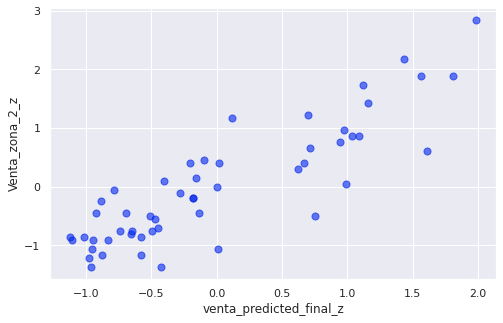

In [ ]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.set_palette('winter')

df.plot(kind="scatter", x="venta_predicted_final_z", y="Venta_zona_2_z", alpha=0.6, s=50)

In [ ]:
df[['venta_predicted_final_z', 'Venta_zona_2_z']].to_csv('results.csv', index=0)